Javier García Serrano, Ana Gil Molina

## <div style="background-color: #54c7ec; color: #fff; font-weight: 700; padding-left: 10px; padding-top: 5px; padding-bottom: 5px"><strong>Ejercicio 4:  (hasta 3 puntos)</strong></div>

Tomando como referencia la arquitectura encoder-decoder que hemos usado y el modelo de atención de Bahdanau, trabaja por tu cuenta en un problema equivalente al de traducción, en el que sea posible aplicar un modelo seq2seq como el que estamos usando. Debes elegir trabajar bien en *Resumen de textos* (3 puntos) bien en *Corrección de errores* (1.5 puntos). Ejemplos de datasets que puedes usar directamente para el primero son los siguientes

<https://www.kaggle.com/datasets/gowrishankarp/newspaper-text-summarization-cnn-dailymail>

<https://www.kaggle.com/datasets/thedevastator/pubmed-article-summarization-dataset>

<https://huggingface.co/datasets/ccdv/arxiv-summarization>

<https://huggingface.co/datasets/ccdv/pubmed-summarization>

y para el segundo 

<https://www.kaggle.com/datasets/satishgunjal/grammar-correction>

<https://huggingface.co/datasets/jhu-clsp/jfleg>

<https://huggingface.co/datasets/vishnun/SpellGram>

Elige el problema, elige el dataset, justifica tu decisión. En el caso de trabajar en resumen de textos, redimensiona el dataset para que esté entre por ecima de las 400MB y no supere las 512MB de tamaño eliminando ejemplos hasta dejar el dataset por debajo de ese tamaño. En ambos casos construye un modelo y visualiza los resultados siguiendo las pautas de ejercicios 2 y 3. Añade cualquier elemento adicional que consideres necesario. En la resolución del ejercicio incluye la especificación del trabajo SLURM, el script en Python completo para su ejecución en el cluster y el análisis de los resultados.

In [ ]:
#Descargar nltk
!pip install nltk
import nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/40.5 kB ? eta -:--:--


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 1.1 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/1.5 MB ? eta -:--:--
   ━━━━━━━━━━━━━╺━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.5/1.5 MB 15.2 MB/s eta 0:00:01


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━ 1.2/1.5 MB 18.2 MB/s eta 0:00:01


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 1.5/1.5 MB 18.8 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/792.7 kB ? eta -:--:--


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 788.5/792.7 kB 30.5 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 792.7/792.7 kB 12.8 MB/s eta 0:00:00


In [2]:
import os

# Cambiar el directorio
os.chdir("C:/Users/gilpe/Desktop/Máster IA/Primer cuatrimestre/Deep Learning para Procesamiento del Lenguaje Natural/Parte I/Práctica/Datos")
print("Directorio actual:", os.getcwd())

Directorio actual: C:\Users\gilpe\Desktop\Máster IA\Primer cuatrimestre\Deep Learning para Procesamiento del Lenguaje Natural\Parte I\Práctica\Datos


In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import csv
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Preprocesamiento de los Datos

Escogemos el problema de resumen de textos. Además, elegimos el dataset que se encuentra en:

<https://www.kaggle.com/datasets/thedevastator/pubmed-article-summarization-dataset>

ya que tiene una estructura y un formato fácil de utilizar y de preprocesar, y además es el que menos instancias tiene en el conjunto de entrenamiento, por lo que reducirle el tamaño puede ser más rápido. Sin embargo, como tiene valores nulos, tendremos que eliminarlos en el preprocesamiento.

In [ ]:
# Aumentar el límite del tamaño de campo
csv.field_size_limit(2**31 - 1)

def preprocess_dataset(input_file, output_file, max_size_mb=512, min_size_mb=400):
    """
    Procesa un dataset eliminando ejemplos nulos y asegurando que esté dentro de un rango de tamaño especificado.
    
    Args:
        input_file (str): Ruta del archivo CSV de entrada con columnas 'article' y 'abstract'.
        output_file (str): Ruta del archivo CSV de salida preprocesado.
        max_size_mb (int): Tamaño máximo del dataset en MB.
        min_size_mb (int): Tamaño mínimo del dataset en MB.
    """
    # Leer el archivo de entrada
    with open(input_file, 'r', encoding='utf-8') as infile:
        reader = csv.DictReader(infile)
        
        # Filtrar filas con valores nulos
        data = [
            {"article": row["article"], "abstract": row["abstract"]}
            for row in reader
            if row["article"] and row["abstract"]  # Verificar que no sean nulos
        ]
    
    print(f"Ejemplos originales (sin nulos): {len(data)}")

    # Redimensionar el dataset para cumplir con los límites de tamaño
    current_size = lambda: os.path.getsize(output_file) / (1024 * 1024)  # MB
    while len(data) > 0:
        # Escribir ejemplos en el archivo temporalmente
        with open(output_file, 'w', encoding='utf-8') as outfile:
            writer = csv.DictWriter(outfile, fieldnames=["article", "abstract"])
            writer.writeheader()
            writer.writerows(data)
        
        # Comprobar el tamaño actual
        dataset_size = current_size()
        print(f"Tamaño actual: {dataset_size:.2f}MB")
        
        if dataset_size < max_size_mb and dataset_size > min_size_mb:
            break  # Tamaño aceptable, detener el ajuste
        elif dataset_size > max_size_mb:
            data = data[:int(len(data) * 0.9)]  # Reducir el tamaño al eliminar el 10% de ejemplos
        else:
            print("El dataset es demasiado pequeño después del ajuste.")
            break

    print(f"Dataset preprocesado guardado en: {output_file} con {len(data)} ejemplos.")

In [27]:
# Verificar si la carpeta data existe, si no, crearla
if not os.path.exists("data"):
    os.makedirs("data")

# Rutas para preprocesar los datos de train
input_file = os.path.join("datasets", "train", "train.csv")
output_file = os.path.join("data", "train_preprocessed.csv")

# Llamada a la función
preprocess_dataset(input_file, output_file)

Ejemplos originales (sin nulos): 117232
Tamaño actual: 2163.37MB
Tamaño actual: 1943.93MB
Tamaño actual: 1751.49MB
Tamaño actual: 1574.90MB
Tamaño actual: 1417.90MB
Tamaño actual: 1272.22MB
Tamaño actual: 1147.01MB
Tamaño actual: 1034.30MB
Tamaño actual: 931.24MB
Tamaño actual: 838.68MB
Tamaño actual: 755.06MB
Tamaño actual: 680.43MB
Tamaño actual: 612.54MB
Tamaño actual: 549.38MB
Tamaño actual: 495.47MB
Dataset preprocesado guardado en: data\train_preprocessed.csv con 26815 ejemplos.


Cada palabra se representará con un vector one-hot. Se necesitará un único índice para cada palabra, y mediante la clase `Lang` podremos llevar la cuenta de todos gracias a los diccionarios `word2index` e `index2word`. Además, para conocer la frecuencia de cada palabra y eliminar aquellas de menor frecuencia, usaremos `word2count`. El número de palabras se almacenará en `n_words`.

In [5]:
SOS_token = 0       # Asignar índice 0 al token SOS inicial
EOS_token = 1       # Asignar índice 1 al token EOS final

class Lang:
    def __init__(self, name):
        self.name = name 
        self.word2index = {}  # Palabra -> índice
        self.word2count = {}  # Palabra -> cantidad de veces que aparece
        self.index2word = {0: "SOS", 1: "EOS"}  # Índice -> palabra
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

Como todos los ficheros son unicode, simplificaremos las cosas pasando todo a ASCII, minúsculas, y eliminando todos los signos de puntuación.

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

Creamos una función `readDataset` que pueda leer los datos en forma de Dataframe de pandas, y normalice los textos.

In [8]:
def readDataset(preprocessed_file):
    """
    Lee un archivo CSV preprocesado y devuelve las oraciones y pares normalizados.
    
    Args:
        preprocessed_file (str): Ruta al archivo CSV preprocesado con columnas 'article' y 'abstract'.

    Returns:
        Lang, Lang, list: Dos objetos Lang (para input y output) y una lista de pares (article, abstract).
    """
    print("Reading preprocessed data...")

    # Leer el archivo CSV preprocesado
    pairs = []
    with open(preprocessed_file, 'r', encoding='utf-8') as infile:
        reader = csv.DictReader(infile)
        for row in reader:
            article = normalizeString(row["article"])
            abstract = normalizeString(row["abstract"])
            pairs.append([article, abstract])

    # Crear objetos Lang
    input_article = Lang("article")
    output_abstract = Lang("abstract")

    return input_article, output_abstract, pairs

Para seleccionar una longitud máxima para los artículos, y así evitar un coste computacional demasiado elevado, calculamos en primer lugar la longitud media y otras medidas estadísticas para la longitud de los artículos:

In [8]:
# Cargar el dataset
df = pd.read_csv('data/train_preprocessed.csv')

# Obtener la longitud de los artículos
df['article_length'] = df['article'].apply(lambda x: len(x.split()))

# Calcular estadísticas descriptivas
print(df['article_length'].describe())

count    26815.000000
mean      3119.445348
std       2320.936943
min          0.000000
25%       1532.000000
50%       2626.000000
75%       4043.000000
max      69894.000000
Name: article_length, dtype: float64


Hacemos lo mismo con los resúmenes para determinar una longitud máxima para los mismos:

In [10]:
# Obtener la longitud de los resúmenes
df['abstract_length'] = df['abstract'].apply(lambda x: len(x.split()))

# Calcular estadísticas descriptivas
print(df['abstract_length'].describe())

count    26815.000000
mean       202.253739
std         77.658962
min         43.000000
25%        143.000000
50%        209.000000
75%        261.000000
max        388.000000
Name: abstract_length, dtype: float64


Modificamos la función `prepareData`, de forma que filtre los pares de datos en los que el artículo supere una logitud de 900 palabras, o el resumen correspondiente supere las 150 palabras. Esto simplifica y acelera el proceso de entrenamiento del modelo. Sin embargo, también podría afectar negativamente a los resultados, ya que se está reduciendo la complejidad y variedad de los ejemplos, excluyendo casos reales de artículos o resúmenes más largos.

In [9]:
# Tamaños máximos para los artículos y los resumenes
MAX_ARTICLE_LENGTH = 900
MAX_ABSTRACT_LENGTH = 150

def prepareData(preprocessed_file):
    input_article, output_abstract, pairs = readDataset(preprocessed_file)
    print(f"Read {len(pairs)} sentence pairs")

    # Eliminamos artículos y resúmenes con longitud 0
    pairs = [pair for pair in pairs if len(pair[0].split(' ')) > 0 and len(pair[1].split(' ')) > 0]
    
    # Eliminamos pares muy largos
    pairs = [pair for pair in pairs if len(pair[0].split(' ')) < MAX_ARTICLE_LENGTH and len(pair[1].split(' ')) < MAX_ABSTRACT_LENGTH]
    
    print(f"Trimmed to {len(pairs)} sentence pairs")
    print("Counting words...")
    for pair in pairs:
        input_article.addSentence(pair[0])
        output_abstract.addSentence(pair[1])
    print(f"Counted words:")
    print(input_article.name, input_article.n_words)
    print(output_abstract.name, output_abstract.n_words)
    
    return input_article, output_abstract, pairs

In [12]:
# Preparar los datos de train
preprocessed_file = os.path.join("data", "train_preprocessed.csv")
input_article, output_abstract, pairs = prepareData(preprocessed_file)
print(random.choice(pairs))

Reading preprocessed data...


Read 26815 sentence pairs


Trimmed to 2516 sentence pairs
Counting words...


Counted words:
article 41317
abstract 17298
['the world health organisation define a central giant cell granuloma as a benign intraosseous lesion consisting of fibrous tissue containing foci of haemorrhage and haemosiderin deposits aggregations of giant cells and reactive bone formation although they represent benign pathology they can be subdivided into locally aggressive and non aggressive types based on clinical radiological and histopathological features they are uncommon lesion with a published incidence of per and they usually occur in older children and young adults their aetiology remains unclear but they appear to have a slight predilection for females radiographically cgcg may appear as a unilocular or multilocular radiolucency the latter exhibiting internal bony septa a positive correlation between the size of the lesion and multilocularity has been found the degree of cortication of the margins dictate the definition of its borders radiographically and tooth displacement an

### Encoder

In [10]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### Decoder basado en atención

In [11]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_ABSTRACT_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

### Entrenamiento

In [12]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_article, pair[0])
    target_tensor = tensorFromSentence(output_abstract, pair[1])
    return (input_tensor, target_tensor)

Modificamos la función `get_dataloader` para ajustarla a los nuevos datos de artículos y resúmenes:

In [13]:
def get_dataloader(batch_size, preprocessed_file):
    input_article, output_abstract, pairs = prepareData(preprocessed_file)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_ARTICLE_LENGTH), dtype=np.int32) 
    target_ids = np.zeros((n, MAX_ABSTRACT_LENGTH), dtype=np.int32) 

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_article, inp)
        tgt_ids = indexesFromSentence(output_abstract, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_article, output_abstract, train_dataloader

In [14]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

Usamos estas funciones para imprimir el tiempo transcurrido en el entrenamiento y el estimado que nos queda, junto con el tiempo actual y su progreso.

In [15]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Una vez definido todo este código, el proceso de entrenamiento consiste en los pasos siguientes

* Lanzamos un temporizador

* Inicializamos los optimizadores y la función de pérdida

* Creamos un conjunto de pares de sentencias para el entrenamiento de la red

* Inicializamos el array de pérdida para el ploteado de su evolución

Tras esto, invocamos a `train` repetidamente y, cada cierto tiempo, imprimimos el progreso del mismo.

In [16]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### Plotear resultados

Para plotear los resultados, usamos `matplotlib` ploteando el contenido de la variable `plot_losses` que hemos ido almacenando durante el entrenamiento.

In [17]:
%matplotlib inline


import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    #plt.show()

### Entrenar la red

El entrenamiento del modelo se ha realizado en el cluster, y los modelos resultantes ya entrenados se han almacenado en una carpeta *models*.

In [18]:
# Ruta de la carpeta donde guardar los modelos
folder_path = 'models/'

# Verificar si la carpeta existe, si no, crearla
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

In [22]:
torch.cuda.empty_cache()

Reading preprocessed data...


Read 26815 sentence pairs


Trimmed to 2516 sentence pairs
Counting words...


Counted words:
article 41317
abstract 17298


6m 25s (- 57m 51s) (10 10%) 4.0002


12m 52s (- 51m 30s) (20 20%) 3.1069


19m 19s (- 45m 4s) (30 30%) 2.6497


25m 46s (- 38m 39s) (40 40%) 2.3463


32m 13s (- 32m 13s) (50 50%) 2.1297


38m 40s (- 25m 46s) (60 60%) 1.9627


45m 6s (- 19m 19s) (70 70%) 1.8267


51m 33s (- 12m 53s) (80 80%) 1.7110


57m 59s (- 6m 26s) (90 90%) 1.6110


64m 26s (- 0m 0s) (100 100%) 1.5220


<Figure size 640x480 with 0 Axes>

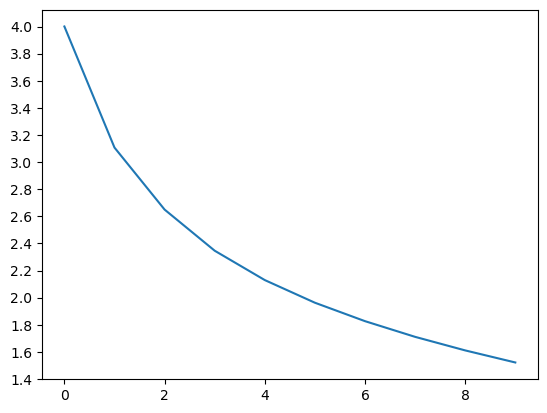

In [23]:
%matplotlib inline

hidden_size = 128
batch_size = 32
n_epochs = 100

# Datos
input_article, output_abstract, train_dataloader = get_dataloader(batch_size, preprocessed_file)

# Modelos
encoder = EncoderRNN(input_article.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_abstract.n_words).to(device)

# Entrenamiento
train(train_dataloader, encoder, decoder, n_epochs, print_every=10, plot_every=10)

# Guardar los modelos dentro de la carpeta
torch.save(encoder.state_dict(), os.path.join(folder_path, 'encoder_resumen.pth'))
torch.save(decoder.state_dict(), os.path.join(folder_path, 'decoder_resumen.pth'))

### Cargar modelo

Una vez entrenados los modelos en el cluster, estos se han guardado en la carpeta *models*. Los descargamos del cluster para poder cargarlos en local ya entrenados, y así evaluar su rendimiento.

In [19]:
# Datos
hidden_size = 128
preprocessed_file = os.path.join("data", "train_preprocessed.csv")
input_article, output_abstract, pairs = prepareData(preprocessed_file)

# Cargar los modelos previamente guardados
encoder = EncoderRNN(input_article.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_abstract.n_words).to(device)

encoder.load_state_dict(torch.load(os.path.join(folder_path, 'encoder_resumen.pth'), map_location=device))
decoder.load_state_dict(torch.load(os.path.join(folder_path, 'decoder_resumen.pth'), map_location=device))

Reading preprocessed data...
Read 26815 sentence pairs
Trimmed to 2516 sentence pairs
Counting words...
Counted words:
article 41317
abstract 17298


C:\Users\gilpe\AppData\Local\Temp\ipykernel_20908\3241064234.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(os.path.join(folder_path

<All keys matched successfully>

### Evaluación

A la hora de evaluar un modelo, lo más adecuado es usar un conjunto de test, distinto del conjunto usado en el entrenamiento del modelo, para evaluar la capacidad de generalización del mismo. Sin embargo, en este caso, puesto que hemos tenido que disminuir en gran medida el conjunto de entrenamiento debido a las limitaciones computacionales, si intentamos usar artículos que no hayan aparecido en el entrenamiento, encontramos el problema de que muchas de las palabras que contienen dichos artículos son desconocidas para el modelo, por lo que su capacidad de generalización es muy limitada, y no da buenos resultados. Por ello, en esta sección haremos una evaluación sobre los mismos datos usados para el entrenamiento. No obstante, es importante dejar claro que esta evaluación no refleja la capacidad de generalización del modelo, y se limita a verificar la capacidad del modelo para aprender patrones específicos del conjunto de entrenamiento.

In [20]:
def evaluate(encoder, decoder, sentence, input_article, output_abstract):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_article, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_abstract.index2word[idx.item()])
    return decoded_words, decoder_attn

In [21]:
def evaluateRandomly(encoder, decoder, input_article, output_abstract, pairs, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_article, output_abstract)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

Para evaluar el modelo, en primer lugar vamos a imprimir algunos artículos, junto con el resumen correcto correspondiente, y el resumen generado por el modelo. Probamos con los datos de entrenamiento:

In [26]:
encoder.eval()
decoder.eval()

# Evaluación del modelo de resumen de textos en train
evaluateRandomly(encoder, decoder, input_article, output_abstract, pairs)

> sclerosing mucoepidermoid carcinoma with eosinophilia smece of the thyroid is a recently recognized primary malignant neoplasm of the thyroid gland associated with hashimoto s thyroiditis lymphocytic thyroiditis till now cases have been reported in the literature that are diagnosed histologically and fine needle aspiration fna from smece often show nonspecific features and most often the diagnosis of a poorly differentiated or undifferentiated carcinoma is rendered in most of the cases but careful examination of cytological features and the background may sometimes be helpful in diagnosis here we describe the cytological features of this rare case along with its differential diagnosis a year old female presented with thyroid swelling for years and ipsilateral lymph node swelling of month duration her physical examination revealed right sided thyroid swelling of cm cm size and lymph node of size cm cm her thyroid profile revealed mild hypothyroidism while routine blood examination and

#### ROUGE Score

Las métricas ROUGE son un conjunto de métricas que se utilizan para evaluar modelos de resumen automático en procesamiento del lenguaje natural. Dichas métricas comparan un resumen generado automáticamente con una referencia de resumen producida por humanos. Las métricas ROUGE oscilan entre 0 y 1, y las puntuaciones más altas indican una mayor similitud entre el resumen generado por el modelo y la referencia. Algunos ejemplos de estas métricas son:

- ROUGE-1: superposición de unigramas entre el resumen generado por el modelo y el resumen de referencia.
- ROUGE-2: superposición de bigramas entre el resumen generado por el modelo y el resumen de referencia.
- ROUGE-L: estadísticas basadas en la subsecuencia común más larga, que identifica los n-gramas más largos que ocurren simultáneamente en las secuencias.

Usando la librería `rouge_score` podemos calcular estas métricas ROUGE para evaluar nuestro modelo:

In [22]:
from rouge_score import rouge_scorer

def calculate_rouge(output_sentence, reference_sentence):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference_sentence, output_sentence)
    return scores

In [29]:
# Tomamos un ejemplo al azar de los pares
pair = random.choice(pairs)

# Obtenemos el resumen generado por el modelo
output_words, _ = evaluate(encoder, decoder, pair[0], input_article, output_abstract)
output_sentence = ' '.join(output_words)

# Obtenemos el resumen correcto
reference_sentence = pair[1] 

# Calculamos el ROUGE score
calculate_rouge(output_sentence, reference_sentence)

{'rouge1': Score(precision=0.358974358974359, recall=0.14432989690721648, fmeasure=0.20588235294117646),
 'rouge2': Score(precision=0.10526315789473684, recall=0.041666666666666664, fmeasure=0.05970149253731344),
 'rougeL': Score(precision=0.23076923076923078, recall=0.09278350515463918, fmeasure=0.1323529411764706)}

Para calcular los promedios de las métricas de ROUGE, modificamos la función `evaluateRandomly` para que en cada ejemplo seleccionado aleatoriamente calcule las métricas ROUGE, y al final calcule el promedio de todos los ejemplos. Nos fijaremos principalmente en la métrica F1, ya que esta muestra un equilibrio entre la precisión y el recall, dado que combina ambas. Esto es importante, ya que:

- Precisión: mide la proporción de palabras en el resumen generado que están en el resumen de referencia.
- Recall: mide la proporción de palabras del resumen de referencia que están en el resumen generado.

De esta forma, evitamos favorecer solo a resúmenes breves (alta precisión) o solo a resúmenes largos (alto recall).

In [23]:
def evaluateRandomly_ROUGE(encoder, decoder, input_article, output_abstract, pairs, n=10):
    total_rouge1_f1 = 0
    total_rouge1_precision = 0
    total_rouge1_recall = 0

    total_rouge2_f1 = 0
    total_rouge2_precision = 0
    total_rouge2_recall = 0

    total_rougeL_f1 = 0
    total_rougeL_precision = 0
    total_rougeL_recall = 0

    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])  # Texto original
        print('=', pair[1])  # Resumen real
        output_words, _ = evaluate(encoder, decoder, pair[0], input_article, output_abstract)
        output_sentence = ' '.join(output_words)  # Resumen generado
        print('<', output_sentence)
        print('')

        # Calcular ROUGE
        rouge_scores = calculate_rouge(output_sentence, pair[1])

        # ROUGE-1
        rouge1_f1 = rouge_scores['rouge1'].fmeasure
        rouge1_precision = rouge_scores['rouge1'].precision
        rouge1_recall = rouge_scores['rouge1'].recall
        total_rouge1_f1 += rouge1_f1
        total_rouge1_precision += rouge1_precision
        total_rouge1_recall += rouge1_recall

        # ROUGE-2
        rouge2_f1 = rouge_scores['rouge2'].fmeasure
        rouge2_precision = rouge_scores['rouge2'].precision
        rouge2_recall = rouge_scores['rouge2'].recall
        total_rouge2_f1 += rouge2_f1
        total_rouge2_precision += rouge2_precision
        total_rouge2_recall += rouge2_recall

        # ROUGE-L
        rougeL_f1 = rouge_scores['rougeL'].fmeasure
        rougeL_precision = rouge_scores['rougeL'].precision
        rougeL_recall = rouge_scores['rougeL'].recall
        total_rougeL_f1 += rougeL_f1
        total_rougeL_precision += rougeL_precision
        total_rougeL_recall += rougeL_recall

        print(f'ROUGE-1 - Precision: {rouge1_precision:.4f}, Recall: {rouge1_recall:.4f}, F1: {rouge1_f1:.4f}')
        print(f'ROUGE-2 - Precision: {rouge2_precision:.4f}, Recall: {rouge2_recall:.4f}, F1: {rouge2_f1:.4f}')
        print(f'ROUGE-L - Precision: {rougeL_precision:.4f}, Recall: {rougeL_recall:.4f}, F1: {rougeL_f1:.4f}')
        print('')

    # Calcular promedios
    avg_rouge1_f1 = total_rouge1_f1 / n
    avg_rouge1_precision = total_rouge1_precision / n
    avg_rouge1_recall = total_rouge1_recall / n

    avg_rouge2_f1 = total_rouge2_f1 / n
    avg_rouge2_precision = total_rouge2_precision / n
    avg_rouge2_recall = total_rouge2_recall / n

    avg_rougeL_f1 = total_rougeL_f1 / n
    avg_rougeL_precision = total_rougeL_precision / n
    avg_rougeL_recall = total_rougeL_recall / n

    print(f'Average ROUGE-1 - Precision: {avg_rouge1_precision:.4f}, Recall: {avg_rouge1_recall:.4f}, F1: {avg_rouge1_f1:.4f}')
    print(f'Average ROUGE-2 - Precision: {avg_rouge2_precision:.4f}, Recall: {avg_rouge2_recall:.4f}, F1: {avg_rouge2_f1:.4f}')
    print(f'Average ROUGE-L - Precision: {avg_rougeL_precision:.4f}, Recall: {avg_rougeL_recall:.4f}, F1: {avg_rougeL_f1:.4f}')

In [38]:
encoder.eval()
decoder.eval()

evaluateRandomly_ROUGE(encoder, decoder, input_article, output_abstract, pairs)

> it is caused by a deficiency of both hexosaminidase hex a and b resulting in accumulation of glycosphingolipids and oligosaccharides in the brain it has three clinical subtypes infantile juvenile and adult forms and represents around of cases among all the lysosomal storage disorders the infantile form presents in the first months of age with regression of milestones developmental delay startle response hypotonia cherry red spots and convulsions we report this case as the infant presented with regression without hepatosplenomegaly and confirmed by gene testing a year old second born male child born to a third degree consanguineously married couple with uneventful perinatal history was brought with regression of milestones and seizures the onset of clinical symptoms began at the age of months with gradual loss of the milestones the child had achieved response to sounds by months head holding social smile and recognition of mother by months of age initially he lost social smile and rec

Los valores de ROUGE score obtenidos sugieren que el modelo tiene dificultades para generar resúmenes que coincidan directamente con los resúmenes de referencia. Sin embargo, en algunos ejemplos observamos como especialmente la precisión de ROUGE-1 es algo más elevada, lo cual sugiere que en estos casos hay una moderada proporción de palabras del resumen generado que también se encuentran en el resumen de referencia. Es decir, se están produciendo algunos resúmenes que contienen ciertas palabras relevantes, pero tiene problemas para capturar relaciones entre las palabras y generar resúmenes completos que coincidan con las secuencias esperadas, tal como se refleja con las métricas de ROUGE-2 y ROUGE-L.

#### BERT Score

El BERT score es una métrica usada para evaluar la calidad de un texto generado por un modelo de lenguaje, que se basa en la similitud semántica entre el texto generado y el de referencia, utilizando los embeddings generados por el modelo de BERT. Este modelo proporciona embeddings contextuales a las palabras de una frase, de forma que genera embeddings diferentes para una misma palabra dependiendo de las palabras a su alrededor y del contexto general de la frase. Esto permite al BERT score capturar de manera más efectiva el significado de las palabras dentro de un contexto, incluso si las palabras exactas en el texto generado y el de referencia no coinciden.

In [24]:
from bert_score import score
from transformers import logging
logging.set_verbosity_error()

def calculate_bertscore(output_sentence, reference_sentence):
    P, R, F1 = score([output_sentence], [reference_sentence], lang="en")
    return {"Precision": P.item(), "Recall": R.item(), "F1": F1.item()}

In [34]:
# Tomamos un ejemplo al azar de los pares
pair = random.choice(pairs)

# Obtenemos el resumen generado por el modelo
output_words, _ = evaluate(encoder, decoder, pair[0], input_article, output_abstract)
output_sentence = ' '.join(output_words)

# Obtenemos el resumen correcto
reference_sentence = pair[1] 

scores = calculate_bertscore(output_sentence, reference_sentence)
print(scores)

{'Precision': 0.8068591356277466, 'Recall': 0.7966262102127075, 'F1': 0.8017100691795349}


In [25]:
def evaluateRandomly_BERT(encoder, decoder, input_article, output_abstract, pairs, n=10):
    total_precision = 0
    total_recall = 0
    total_f1 = 0

    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])  # Texto original
        print('=', pair[1])  # Resumen real
        output_words, _ = evaluate(encoder, decoder, pair[0], input_article, output_abstract)
        output_sentence = ' '.join(output_words)  # Resumen generado
        print('<', output_sentence)
        print('')

        # Calcular BERT Score
        bert_scores = calculate_bertscore(output_sentence, pair[1])
        precision = bert_scores['Precision']
        recall = bert_scores['Recall']
        f1 = bert_scores['F1']

        total_precision += precision
        total_recall += recall
        total_f1 += f1

        print(f'BERTScore Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}')
        print('')
    
    # Calcular promedios
    avg_precision = total_precision / n
    avg_recall = total_recall / n
    avg_f1 = total_f1 / n

    print(f'Average BERTScore Precision over {n} articles: {avg_precision:.4f}')
    print(f'Average BERTScore Recall over {n} articles: {avg_recall:.4f}')
    print(f'Average BERTScore F1 over {n} articles: {avg_f1:.4f}')

In [26]:
encoder.eval()
decoder.eval()

evaluateRandomly_BERT(encoder, decoder, input_article, output_abstract, pairs)

> this year old housewife educated up to sixth standard hailing from middle socioeconomic status with nil contributory family history and suffering from hypertension and myopia in left eye and hypermetropia in right eye reported to outpatient clinic with history of years duration characterized by unpleasant frequent and distressing doubts related to dirt and contamination these resulted in performance of long nonfunctional repetitive activities like cleaning and saying same words again and again it was also reported both by husband and the patient herself that these symptoms have a seasonal pattern appearing in october and complete resolution in april may this seasonal pattern was so well recognized that no treatment was taken for initial years as they considered it an effect of change of season and that symptoms would disappear once the winter is over no associated stress or precipitating factor was identified that might lead to reoccurrence of these symptoms every year in winter grad

Aunque las métricas de ROUGE mostraron un desempeño bajo del modelo, esto puede deberse a que estas métricas son muy estrictas, ya que requieren que haya coincidencias exactas de palabras o n-gramas entre el resumen generado y el de referencia. Sin embargo, al observar el BERT score, se aprecia que en realidad el desempeño del modelo es considerablemente alto, ya que se obtienen promedios cercanos a $0.8$, lo cual indica que los resúmenes generados mantienen una fuerte similitud semántica con los correspondientes resúmenes de referencia, incluso si no coinciden palabra por palabra.

No obstante, en la mayoría de ejemplos se obtiene un recall ligeramente menor que la precisión, lo que sugiere que el modelo genera resúmenes con palabras relevantes y alineadas con el significado del texto de referencia, pero tiende a omitir cierta información importante del texto original.